## JupyterSDRDisplay Test Notebook:
> - continuous spectrogram spectrum from stick (use demo_waterfall.py as base).
> - finds frequencies in the spectrogram that fit a model (avg db, snr, on, etc...)
> - assigns a worker to monitor the frquencies that 'fit' the model.
>   - worker records, catalogs signal when receiving a broadccast on assigned frequency
>   - workers with signals are displayed in the spectrogram UI.

In [296]:
%matplotlib inline

In [315]:
from __future__ import division
import matplotlib.animation as animation
from matplotlib.mlab import psd
import pylab as pyl
import numpy as np
import sys
from rtlsdr import RtlSdr

In [316]:
# A simple waterfall, spectrum plotter
#
# Controls:
#
# * Scroll mouse-wheel up or down, or press the left or right arrow keys, to
#   change the center frequency (hold shift for finer control).
# * Press "+" and "-" to control gain, and space to enable AGC.
# * Type a frequency (in MHz) and press enter to directly change the center frequency

In [317]:
NFFT = 1024*4
NUM_SAMPLES_PER_SCAN = NFFT*16
NUM_BUFFERED_SWEEPS = 100

# change this to control the number of scans that are combined in a single sweep
# (e.g. 2, 3, 4, etc.) Note that it can slow things down
NUM_SCANS_PER_SWEEP = 1

# these are the increments when scrolling the mouse wheel or pressing '+' or '-'
FREQ_INC_COARSE = 1e6
FREQ_INC_FINE = 0.1e6
GAIN_INC = 5

```python
    """
    `TimedAnimation` subclass that makes an animation by repeatedly calling
    a function *func*.

    .. note::

        You must store the created Animation in a variable that lives as long
        as the animation should run. Otherwise, the Animation object will be
        garbage-collected and the animation stops.

    Parameters
    ----------
    fig : `~matplotlib.figure.Figure`
        The figure object used to get needed events, such as draw or resize.

    func : callable
        The function to call at each frame.  The first argument will
        be the next value in *frames*.   Any additional positional
        arguments can be supplied using `functools.partial` or via the *fargs*
        parameter.

        The required signature is::

            def func(frame, *fargs) -> iterable_of_artists

        It is often more convenient to provide the arguments using
        `functools.partial`. In this way it is also possible to pass keyword
        arguments. To pass a function with both positional and keyword
        arguments, set all arguments as keyword arguments, just leaving the
        *frame* argument unset::

            def func(frame, art, *, y=None):
                ...

            ani = FuncAnimation(fig, partial(func, art=ln, y='foo'))

        If ``blit == True``, *func* must return an iterable of all artists
        that were modified or created. This information is used by the blitting
        algorithm to determine which parts of the figure have to be updated.
        The return value is unused if ``blit == False`` and may be omitted in
        that case.

    frames : iterable, int, generator function, or None, optional
        Source of data to pass *func* and each frame of the animation

        - If an iterable, then simply use the values provided.  If the
          iterable has a length, it will override the *save_count* kwarg.

        - If an integer, then equivalent to passing ``range(frames)``

        - If a generator function, then must have the signature::

             def gen_function() -> obj

        - If *None*, then equivalent to passing ``itertools.count``.

        In all of these cases, the values in *frames* is simply passed through
        to the user-supplied *func* and thus can be of any type.

    init_func : callable, optional
        A function used to draw a clear frame. If not given, the results of
        drawing from the first item in the frames sequence will be used. This
        function will be called once before the first frame.

        The required signature is::

            def init_func() -> iterable_of_artists

        If ``blit == True``, *init_func* must return an iterable of artists
        to be re-drawn. This information is used by the blitting algorithm to
        determine which parts of the figure have to be updated.  The return
        value is unused if ``blit == False`` and may be omitted in that case.

    fargs : tuple or None, optional
        Additional arguments to pass to each call to *func*. Note: the use of
        `functools.partial` is preferred over *fargs*. See *func* for details.

    save_count : int, optional
        Fallback for the number of values from *frames* to cache. This is
        only used if the number of frames cannot be inferred from *frames*,
        i.e. when it's an iterator without length or a generator.

    interval : int, default: 200
        Delay between frames in milliseconds.

    repeat_delay : int, default: 0
        The delay in milliseconds between consecutive animation runs, if
        *repeat* is True.

    repeat : bool, default: True
        Whether the animation repeats when the sequence of frames is completed.

    blit : bool, default: False
        Whether blitting is used to optimize drawing.  Note: when using
        blitting, any animated artists will be drawn according to their zorder;
        however, they will be drawn on top of any previous artists, regardless
        of their zorder.
        
        # Disable blitting. The matplotlib.animation's restore_region()
        # method is only implemented for the Agg-based backends,
        # which the macosx backend is not.
    cache_frame_data : bool, default: True
        Whether frame data is cached.  Disabling cache might be helpful when
        frames contain large objects.
    """
#     def __init__(self, fig, func, frames=None, init_func=None, fargs=None, save_count=None, *, cache_frame_data=True, **kwargs):
```

In [337]:
class Waterfall(object):
    image_buffer = -100*np.ones((NUM_BUFFERED_SWEEPS,\
                                 NUM_SCANS_PER_SWEEP*NFFT))

    def __init__(self, sdr=None, fig=None):
        self.fig = fig if fig else pyl.figure()
        self.sdr = sdr if sdr else RtlSdr()

        self.init_plot()

    def init_plot(self):
        print(f'called init_plot')

        self.ax = self.fig.add_subplot(1,1,1)
        self.image = self.ax.imshow(self.image_buffer, aspect='auto',\
                                    interpolation='nearest', vmin=-50, vmax=10)
        self.ax.set_xlabel('Current frequency (MHz)')
        self.ax.get_yaxis().set_visible(False)

    def update_plot_labels(self):
        print(f'called update_plot_labels')
        fc = self.sdr.fc
        rs = self.sdr.rs
        freq_range = (fc - rs/2)/1e6, (fc + rs*(NUM_SCANS_PER_SWEEP - 0.5))/1e6

        self.image.set_extent(freq_range + (0, 1))
        self.fig.canvas.draw_idle()

    def update(self, *args):
        # save center freq. since we're gonna be changing it
        print(f'called update')
        start_fc = self.sdr.fc

        # prepare space in buffer
        # TODO: use indexing to avoid recreating buffer each time
        self.image_buffer = np.roll(self.image_buffer, 1, axis=0)

        for scan_num, start_ind in enumerate(range(0, NUM_SCANS_PER_SWEEP*NFFT, NFFT)):
            self.sdr.fc += self.sdr.rs*scan_num

            # estimate PSD for one scan
            samples = self.sdr.read_samples(NUM_SAMPLES_PER_SCAN)
            
            psd_scan, f = psd(samples, NFFT=NFFT)

            self.image_buffer[0, start_ind: start_ind+NFFT] = 10*np.log10(psd_scan)

        # plot entire sweep
        self.image.set_array(self.image_buffer)

        # restore original center freq.
        self.sdr.fc = start_fc
        
        return self.image,

    def start(self):
        print(f'called start')
        self.update_plot_labels()
        
#         if sys.platform == 'darwin':
#             blit = False
#         else:
#             blit = True     
#         ani = animation.FuncAnimation(self.fig, self.update, interval=50, blit=blit)

        pyl.show()

In [342]:
def main_orig():

    sdr = RtlSdr()
    sdr.rs = 2.4e6
    sdr.fc = 100e6
    sdr.gain = 10
    
    fig = pyl.figure()
    
    wf = Waterfall(sdr, fig)

    if sys.platform == 'darwin':
        blit = False
    else:
        blit = True

    wf.start()
    
    ani = animation.FuncAnimation(fig, wf.update, 
                                  interval=50, 
                                  blit=blit, 
                                  save_count=4096
                                 )
    while True:
        wf.update()
#         pyl.show()
    
    sdr.close()

In [343]:
if __name__ == '__main__':
    main_orig()


Kernel driver is active, or device is claimed by second instance of librtlsdr.
In the first case, please either detach or blacklist the kernel module
(dvb_usb_rtl28xxu), or enable automatic detaching at compile time.

usb_claim_interface error -3


LibUSBError: <LIBUSB_ERROR_ACCESS (-3): Access denied (insufficient permissions)> "Could not open SDR (device index = 0)"

In [295]:
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [292]:
def main_bokeh():

    sdr = RtlSdr()
    
    wf = Waterfall(sdr)

    # some defaults
    sdr.rs = 2.4e6
    sdr.fc = 100e6
    sdr.gain = 10
    
    anim = None    
    anim = wf.start()
    
#     print(f"anim {pyl}")
#     pyl.show()




    # cleanup
    sdr.close()

Found Rafael Micro R820T/2 tuner


anim <module 'pylab' from '/Users/scooper/anaconda3/envs/MagPyEnvironment/lib/python3.9/site-packages/pylab.py'>


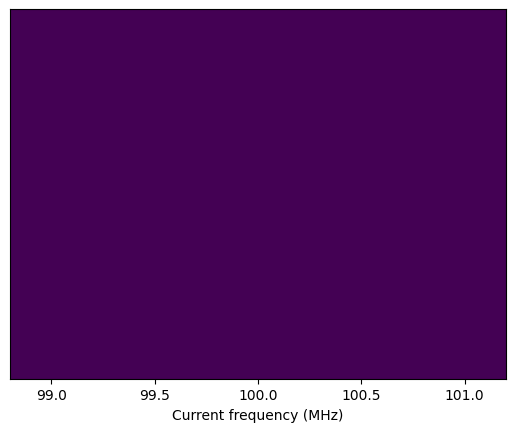

In [83]:
if __name__ == '__main__':
    main_bokeh()